In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [7]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
#model.cuda()
model.eval()
classes = utils.load_classes(class_path)
#Tensor = torch.cuda.FloatTensor
Tensor = torch.FloatTensor

In [8]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.312145
tensor(16.7907) tensor(98.2091) tensor(105.3135) tensor(312.7199) tensor(0.9990) tensor(0.9998) tensor(0.)
tensor(202.0034) tensor(93.1675) tensor(274.3496) tensor(326.2698) tensor(0.9983) tensor(1.0000) tensor(0.)
tensor(140.1650) tensor(102.5723) tensor(206.2020) tensor(318.7103) tensor(0.9982) tensor(0.9999) tensor(0.)
tensor(313.9986) tensor(112.1363) tensor(401.0854) tensor(319.9106) tensor(0.9932) tensor(0.9996) tensor(0.)
tensor(280.9722) tensor(129.2590) tensor(335.8708) tensor(304.6920) tensor(0.9584) tensor(0.9829) tensor(0.)
tensor(261.6166) tensor(150.3011) tensor(294.9841) tensor(282.2072) tensor(0.9401) tensor(0.9998) tensor(0.)


<Figure size 432x288 with 0 Axes>

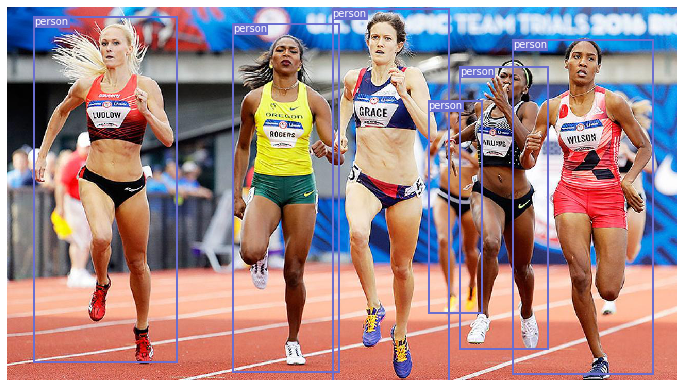

In [15]:
# load image and get detections
img_path = "images/olympic-trials.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        print(x1, y1, x2, y2, conf, cls_conf, cls_pred)
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

In [17]:
class Object(object):
    def __init__(self):
        self.name = "Tensor Flow Object API Service 0.0.1"
        
    def toJSON(self):
        return json.dumps()
    
def get_objects(image, threshold=0.5):
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    classes = np.squeeze(classes).astype(np.int32)
    scores = np.squeeze(scores)
    boxes = np.squeeze(boxes)
    obj_above_thresh = sum(n > threshold for n in scores)

    obj_above_thresh = sum(n > threshold for n in scores)
    print("detected %s objects in image above a %s score" % (obj_above_thresh, threshold))
    
    output = []

    #Add some metadata to the output
    item = Object()
    item.numObjects = obj_above_thresh
    item.threshold = threshold
    output.append(item)

    for c in range(0, len(classes)):
        class_name = category_index[classes[c]]['name']
        if scores[c] >= threshold:      # only return confidences equal or greater than the threshold
            print(" object %s - score: %s, coordinates: %s" % (class_name, scores[c], boxes[c]))

            item = Object()
            item.name = 'Object'
            item.class_name = class_name
            item.score = float(scores[c])
            item.y = float(boxes[c][0])
            item.x = float(boxes[c][1])
            item.height = float(boxes[c][2])
            item.width = float(boxes[c][3])

            output.append(item)

    outputJson = json.dumps([ob.__dict__ for ob in output])
    return outputJson

In [18]:
import scan_image
import os
from PIL import Image

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images' #cwh
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    response = object_detection_api.get_objects(image)
    print("returned JSON: \n%s" % response)

ModuleNotFoundError: No module named 'scan_image'